#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../infras/')
sys.path.append('../infras/dashboards/')
sys.path.append('../experiments/')
sys.path.append('../experiments/pipeline/')
sys.path.append('../preprocess/cell_specifics/')
sys.path.append('../preprocess/intra_variance/')
sys.path.append('../models/cell_proportions/')
sys.path.append('../measures/cell_proportions_measures/')

In [2]:
from data_factory import DataFactory

from global_utils import GlobalUtils

from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
import exploration_cytof_plots as cytof_plots

from basic import BasicDeconv
from pp_entropy_based import PpEntropyBased
from cell_proportions_measure import CellProportionsMeasure
from pp_clean_high_intra_var import PpCleanHighIntraVar
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins
from pp_empty import PpEmpty
from pp_entropy_based_only_largest import PpEntropyBasedOnlyLargest
from aggregate_intra_variance import AggregateIntraVariance
from pipeline_deconv import PipelineDeconv

In [1]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing
from sklearn import pipeline
import itertools

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import os
import pickle as pkl 

In [4]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

# from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

from cellMix_coordinator import CellMixCoordinator

In [5]:
%connect_info

{
  "shell_port": 64709,
  "iopub_port": 64710,
  "stdin_port": 64711,
  "control_port": 64712,
  "hb_port": 64713,
  "ip": "127.0.0.1",
  "key": "ffaf0e5a-d962065f3a939675729e707d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5ce991a8-a139-4f9c-a111-63ad45690213.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# read and build any data

## simple artificial 

In [6]:
data_factory = DataFactory()
# A_all_ar,B_ar,X_ar = data_factory.load_simple_artificial_profile("Intensity",index_func=lambda x:x,sample_to_pick="all")

## simple IBD

In [7]:
# A,B = data_factory.load_simple_IBD_profile("Intensity",index_func=lambda x:x,log2_transformation=True)

## IBD with A/B_all_vs

In [8]:
# A_all_vs,_ = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x,log2_transformation=True)
# A_all_vs,B_all_vs = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x,log2_transformation=True)

## IBD with A/B_all_vs with A_Intensity

In [9]:
# A_all_vs, B_all_vs ,A_intensity, B_intensity = data_factory.load_IBD_vs_A_and_B_intensity("Intensity",index_func=lambda x:x,log2_transformation=True)

## simulated_data

In [10]:
# A,X,B = data_factory.build_simulated_data()
# _,X,B = data_factory.build_simulated_data()

# with open("../cache/simulated_X_cache",'rb') as f : 
#     X = pkl.load(f)
# with open("../cache/simulated_B_cache","rb") as f : 
#     B = pkl.load(f)
# with open("../cache/simulated_A_cache","rb") as f : 
#     A = pkl.load(f)

## cytof data

In [11]:
# cytof_label_prop_A_ints = cci.cytof_label_propagation(A_intensity)
# A_intensity_Cytof_cell,cytof_count_of_A_intensity = cci.return_mass_and_cytof_not_none_cells_counts(A_intensity.T,cytof_label_prop_A_ints)
# A_intensity_Cytof_cell = A_intensity_Cytof_cell.T

# visualize data

# preprocess with model result - no cytof

In [12]:
# pp_eb = PpEntropyBased()
# bd=BasicDeconv()
# cpm = CellProportionsMeasure()

# steps = [("deconv_py",pp_eb),("BasicDeconv",bd)]
# ppline = pipeline.Pipeline(steps)
# result = ppline.predict([A,B])
# corr = cpm.correlation_measure(result,X)

In [13]:
# raise

# preprocess with model results - with cytof

# preprocess with model results - with intra variance 

In [14]:
# pp_eb = PpEntropyBased()
# bd=BasicDeconv()
# cpm = CellProportionsMeasure()
# chiv = PpCleanHighIntraVar()

# steps = [("high_intra_var",chiv),("entropy_base",pp_eb),("BasicDeconv",bd)]
# ppline = pipeline.Pipeline(steps)
# result = ppline.predict([A,B])
# corr = cpm.correlation_measure(result,X)

# run model - with and without cell mix

In [15]:
# bd = BasicDeconv(cellMix=True)
# bd.predict([A,B])


# build the meta pipeline - cytof

In [16]:
agg_iv,pp_irl_prot  = AggregateIntraVariance(),PpCleanIrrelevantProteins()
pp_chiv = PpCleanHighIntraVar()
pp_entropy_only_largest,pp_entropy,pp_empty = PpEntropyBasedOnlyLargest(),PpEntropyBased(),PpEmpty()
bd = BasicDeconv()
cpm = CellProportionsMeasure(how="groups")

hyper_configuration = [
    # {"step_name": "cleanHighIntraVariance",
    #                     "steps": [
    #                         {"function_name": "PpCleanHighIntraVar", "function": pp_chiv,
    #                          "params": {"how": ["range"],"range_trh":[1,2,5]}}]},
                        # -------------------------------
                        {"step_name": "AggregateIntraVariance",
                        "steps": [
                            {"function_name": "AggregateIntraVariance", "function": agg_iv,
                             "params": {"how": ["mean"]}}]},
                       # --------------------------------
                       {"step_name": "cleen_irrelevant_proteins",
                        "steps": [
                            {"function_name": "CleanIrrelevantProteins", "function": pp_irl_prot,
                             "params": {}}]},
                       # --------------------------------
                       {"step_name": "Cytof_X_Building",
                        "steps": [
                            {"function_name": "Cytof_X_Building", "function": pp_empty,
                             "params": {"keep_labels":[True],"with_label_prop":[False]}}]},
                       # --------------------------------
                       {"step_name": "preprocess",
                        "steps": [
#                             {"function_name": "PpEntropyBased", "function": pp_entropy,
#                              "params": {"n_genes_per_cell": [5,20], "gene_entropy_trh": [0.0001],
#                                         "with_norm": [False, True]}},
#                             {"function_name": "PpEntropyBasedOnlyLargest", "function": pp_entropy_only_largest,
#                              "params": {"n_genes_per_cell": [5, 15], "gene_entropy_trh": [0.0001],
#                                         "with_norm": [True, False]}},
                            {"function_name": "PpEmpty", "function": pp_empty,
                             "params": {}}
                        ]},
                       # --------------------------------
                       {"step_name": "deconv",
                        "steps": [
                            {"function_name": "BasicDeconv", "function": bd,
                             "params": {"normalize": [True], "cellMix": [ False]}}]}]

hyper_measure_configuration = [
    {"step_name": "measure",
     "steps": [
         {"function_name": "CellProportionsMeasure", "function": cpm,
          "params": {"how": ["correlation"]}}]}]

_pipe = PipelineDeconv(hyper_configuration=hyper_configuration,
                                 hyper_measure_configuration=hyper_measure_configuration)

In [17]:
data_factory = DataFactory()
A_all_vs, B_all_vs = data_factory.load_IBD_all_vs("Intensity", index_func=lambda x: x, log2_transformation=True)

results = _pipe.run_cytof_pipeline(A_all_vs, B_all_vs)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


In [22]:
_pipe.load_results_from_archive("2814562996")

{'known': mixtures                      HR-38-V1  HR-42-V1  HR-42-V2  HR-42-V3  \
 B cells                       0.082833  0.056656  0.098014  0.122381   
 CD4+ effector memory T cells  0.329556  0.283301  0.335832  0.272587   
 CD4+central memory Tcells     0.014510  0.042336  0.020397  0.022774   
 CD8+ effector memory T cells  0.108394  0.140357  0.166971  0.137069   
 Monocytes                     0.335328  0.163906  0.136869  0.195038   
 Na?ve CD4 Tcell               0.039623  0.121897  0.068686  0.076494   
 Na?ve CD8 Tcell               0.071450  0.170145  0.156127  0.157034   
 Plasmacytoid dendritic cells  0.018307  0.021401  0.017105  0.016623   
 
 mixtures                      HR-44-V1  HR-44-V2  HR-44-V3  HR-46-V1  \
 B cells                       0.109494  0.211939  0.234753  0.046421   
 CD4+ effector memory T cells  0.197428  0.273552  0.249900  0.233422   
 CD4+central memory Tcells     0.009813  0.002487  0.003579  0.043033   
 CD8+ effector memory T cells  0.091585 

In [21]:
results["uuid"]

0    2814562996
Name: uuid, dtype: int64

In [19]:
best_results=best_results_and_known["result"]
best_known=best_results_and_known["known"].rename(columns=GlobalUtils.get_corospanding_columns_map(best_known,best_results))

NameError: name 'best_results_and_known' is not defined

In [23]:
best_results_and_known = _pipe.load_results_from_archive(results.iloc[0]["uuid"])

In [28]:
best_results=best_results_and_known["result"]
best_known = best_results_and_known["known"] 
best_known=best_known.rename(columns=GlobalUtils.get_corospanding_columns_map(best_known,best_results))

# examine best results 

# plot experiment params summary 

In [25]:
def display_result(cell_abundance, res_as_cytof, as_heatmap, added_title=""):
    if cell_abundance is None:
        return None
    if res_as_cytof is not None:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        sns.heatmap(res_as_cytof.sort_index(), ax=axs[1])
        axs[1].set_title("mass as cytof results" + added_title)

    if as_heatmap:
        if res_as_cytof is None:
            fig, axs = plt.subplots(1, 1)
        sns.heatmap(cell_abundance, ax=axs[0])
        axs[0].set_title("cell abundance" + added_title)
        plt.subplots_adjust(wspace=1)
        plt.show()
    else:
        print(cell_abundance.style.set_caption("cell abundance" + added_title))

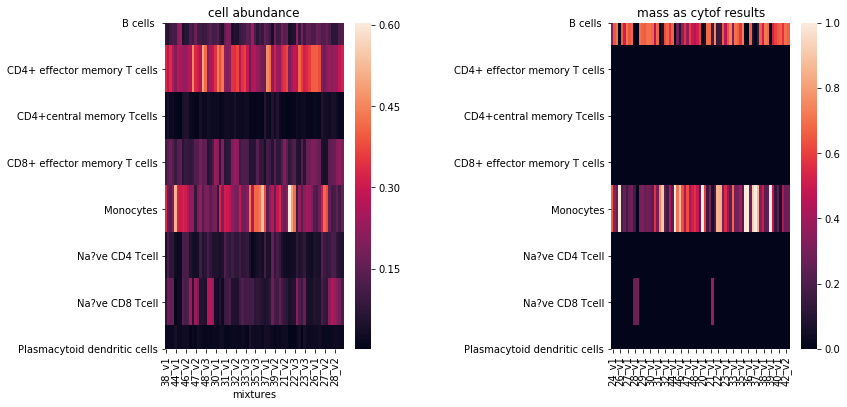

In [30]:
display_result(best_known,best_results,True)

In [35]:
best_known = best_known.drop(columns=['46_v2', '33_v2', '40_v2', '39_v3'])

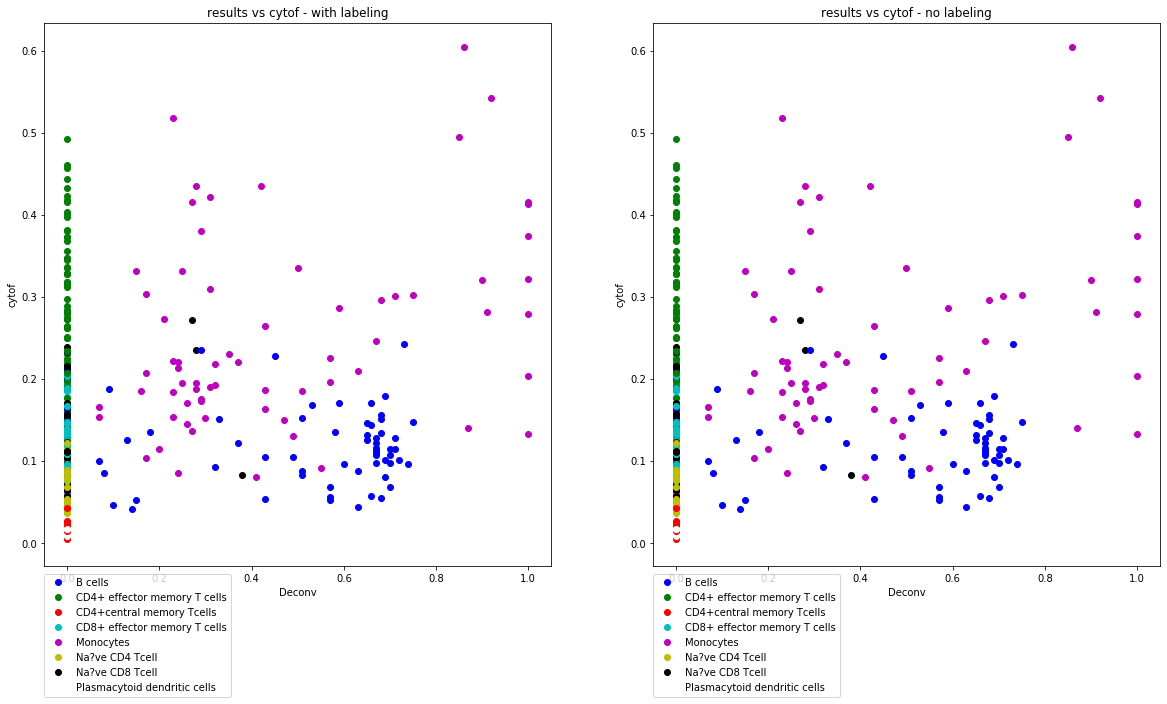

In [36]:
cytof_plots.plot_mass_to_cytof_scatter_all_on_one(best_results,best_known,best_results)

# test

In [43]:
A = pd.DataFrame([[1,10,11,12],[2,20,22,24],[3,30,33,36],[4,40,44,48]])/10
B = pd.DataFrame([[1,3,5],[2,6,10],[4,9,15],[8,12,30]])


In [44]:
A

,0,1,2,3
0,0.1,1.0,1.1,1.2
1,0.2,2.0,2.2,2.4
2,0.3,3.0,3.3,3.6
3,0.4,4.0,4.4,4.8


In [45]:
B

,0,1,2
0,1,3,5
1,2,6,10
2,4,9,15
3,8,12,30


In [70]:
A.max().max()

4.8

0    1.0
1    1.0
2    1.0
dtype: float64

In [61]:
B.max(axis=0)

0     8
1    12
2    30
dtype: int64

0    0.24
1    0.24
2    0.24
3    0.16
dtype: float64

In [62]:
1.2/8

0.15